<a href="https://colab.research.google.com/github/singhabhinay505/Rossmann-Drug-Store-Sales-Prediction/blob/main/Copy_of_rossmann_sales_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
plt.style.use( 'ggplot' )
sns.set_style( 'white' )

In [ ]:
rossmann = pd.read_csv("/content/drive/MyDrive/Regression project/Copy of Rossmann Stores Data.csv")
store = pd.read_csv("/content/drive/MyDrive/Regression project/Copy of store.csv")

In [ ]:
rossmann.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [ ]:
rossmann.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
rossmann.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
rossmann.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
rossmann.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [ ]:
rossmann.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

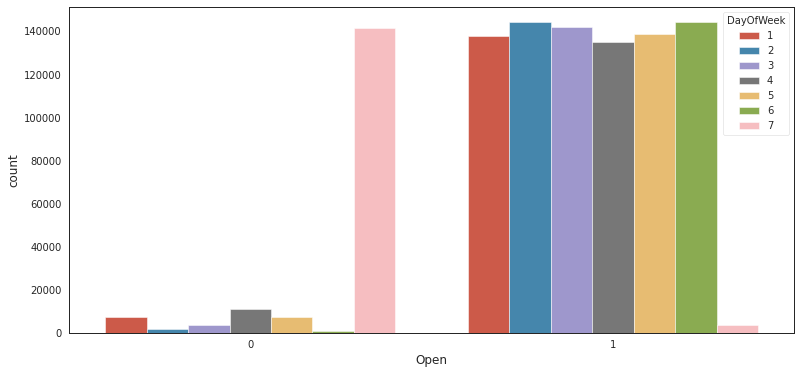

In [ ]:
plt.figure(figsize=(13,6))
sns.countplot(x='Open',hue='DayOfWeek', data=rossmann)
plt.show()

In [ ]:
def extract1(x):
    return int(str(x)[:4])

def extract2(x):
    return int(str(x)[5:7])

def extract3(x):
    return (str(x)[:7])

In [ ]:
rossmann['Date'] = rossmann['Date'].apply(extract3)
rossmann['Month'] = rossmann['Date'].apply(extract2)
rossmann['Year'] = rossmann['Date'].apply(extract1)

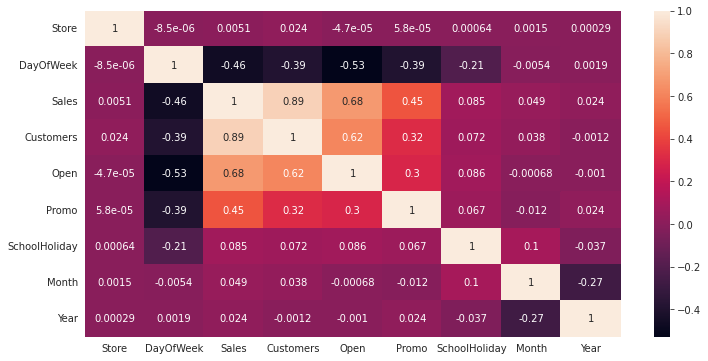

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(rossmann[rossmann.columns].corr(),annot=True)
plt.show()

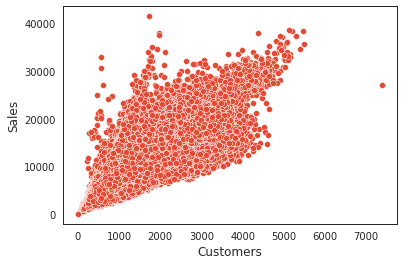

In [ ]:
sns.scatterplot(data=rossmann,x='Customers',y='Sales')
plt.show()

In [ ]:
def plotter(StringA , StringB):
  fig, axes = plt.subplots(2,1)
  fig.set_size_inches(15, 10)
  sns.barplot(x=StringA, y=StringB, data=rossmann ,hue="DayOfWeek", ax = axes[0])
  sns.boxplot(x=StringA, y=StringB, data=rossmann ,hue="DayOfWeek", ax=axes[1])

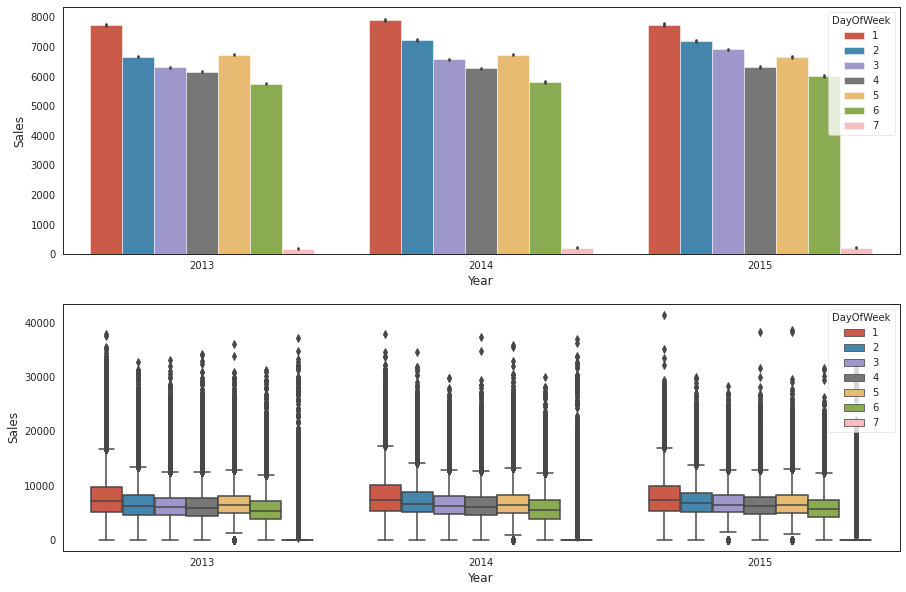

In [ ]:
plotter('Year','Sales')

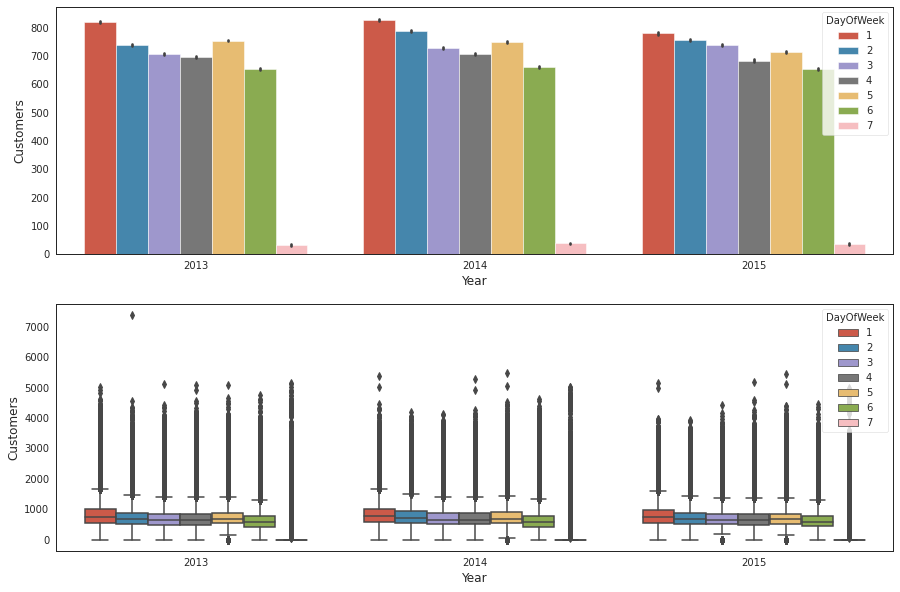

In [ ]:
plotter("Year","Customers")

In [ ]:
rossmann["StateHoliday"] = rossmann["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

In [ ]:
rossmann.StateHoliday.value_counts()

0    986159
1     31050
Name: StateHoliday, dtype: int64

In [ ]:
rossmann.SchoolHoliday.value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

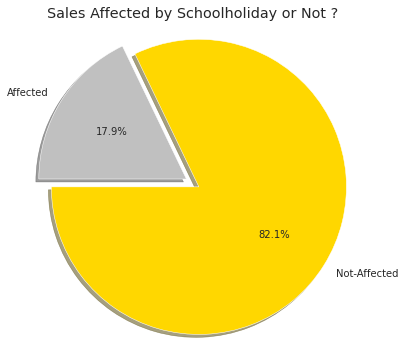

In [ ]:
labels = 'Not-Affected' , 'Affected'
sizes = rossmann.SchoolHoliday.value_counts()
colors = ['gold', 'silver']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Sales Affected by Schoolholiday or Not ?")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

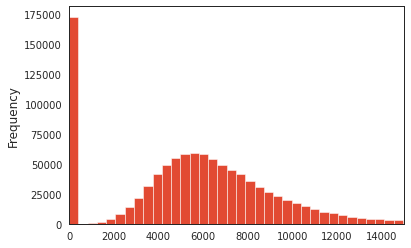

In [ ]:
rossmann["Sales"].plot(kind='hist',bins=100,xlim=(0,15000))
plt.show()

0 is raised beacause 172817 times the store was closed 

In [ ]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store.shape

(1115, 10)

In [ ]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
store.isnull().sum().sort_index(ascending=False)

StoreType                      0
Store                          0
PromoInterval                544
Promo2SinceYear              544
Promo2SinceWeek              544
Promo2                         0
CompetitionOpenSinceYear     354
CompetitionOpenSinceMonth    354
CompetitionDistance            3
Assortment                     0
dtype: int64

In [ ]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
temp = []
for i in rossmann.groupby('Store')[["Sales", "Customers"]].mean()["Sales"]:
  temp.append(i)
store["Sales"] = temp

In [ ]:
temp = []
for i in rossmann.groupby('Store')[["Sales", "Customers"]].mean()["Customers"]:
  temp.append(i)
store["Customers"] = temp

In [ ]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,Customers
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3945.704883,467.646497
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",4122.991507,486.045648
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",5741.253715,620.286624
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,8021.769639,1100.057325
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,3867.110403,444.360934


In [ ]:
store.StoreType.value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

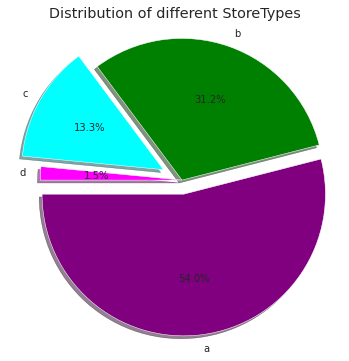

In [ ]:
labels = 'a','b','c','d'
sizes = store.StoreType.value_counts()
colors = 'purple','green','cyan','magenta'
explode = 0.1,0.0,0.15,0.0
plt.pie(sizes,explode=explode,labels=labels,colors=colors,shadow=True,autopct='%1.1f%%',startangle= 180)
plt.axis('equal')
plt.title("Distribution of different StoreTypes")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

In [ ]:
def plotnew(StringA , StringB):
  fig, axes = plt.subplots(2,1)
  fig.set_size_inches(12, 15)
  sns.barplot(x=StringA, y=StringB, data=store ,hue="StoreType", ax = axes[0])
  sns.boxplot(x=StringA, y=StringB, data=store ,hue="StoreType", ax=axes[1])

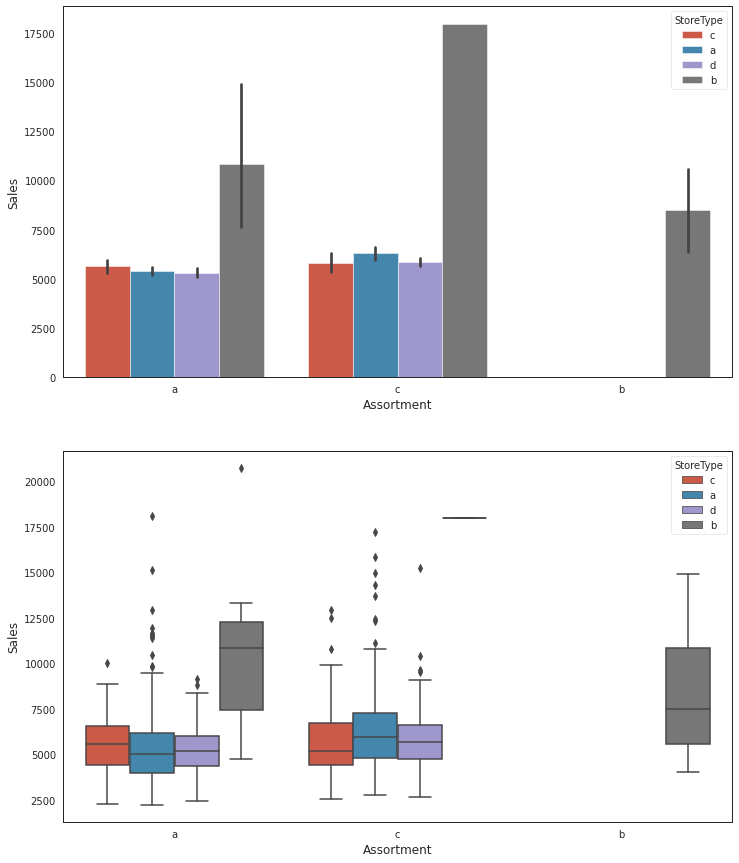

In [ ]:
plotnew("Assortment" , "Sales")

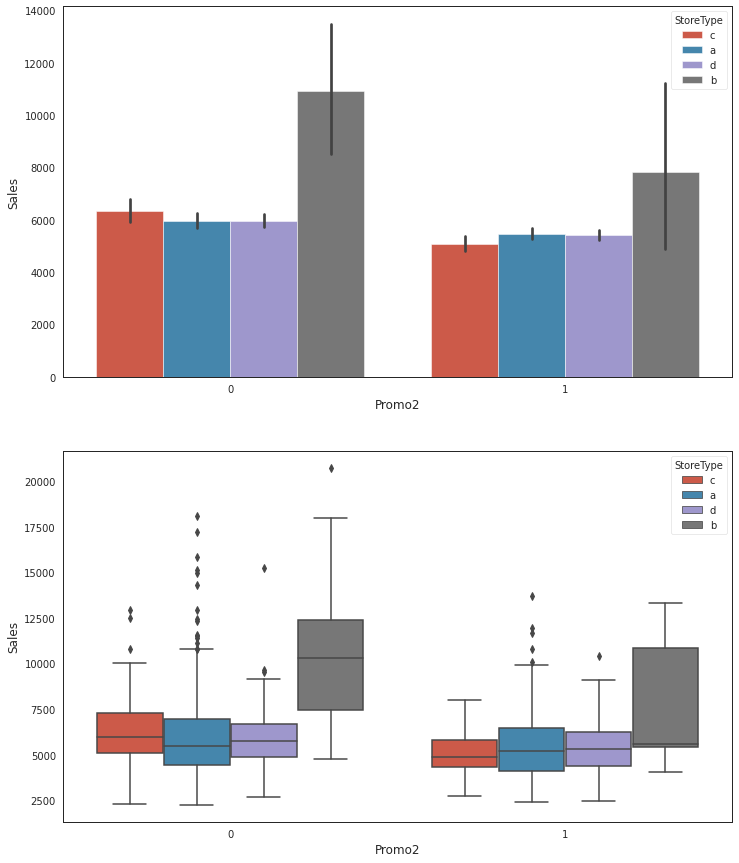

In [ ]:
plotnew("Promo2" , "Sales")

Stores which are open on sunday

In [ ]:
rossmann[(rossmann.Open == 1) & (rossmann.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8929b32410>,
      dtype=object)

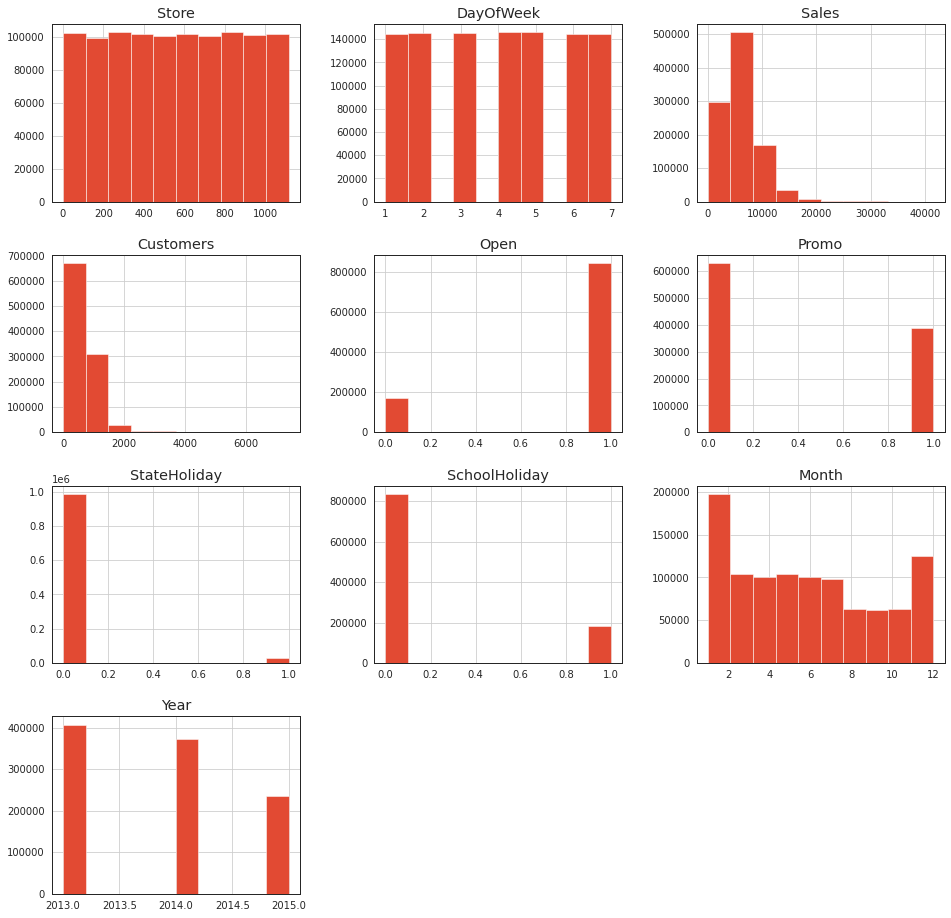

In [ ]:
rossmann.hist(figsize=(16,16))

Sales data are right-skewed. We can log transform the data to remove this skewness.



In [ ]:
rossmann = rossmann[rossmann["Open"] != 0]
rossmann = rossmann[rossmann["Sales"] > 0]
rossmann['log_sales'] = np.log(rossmann['Sales'])

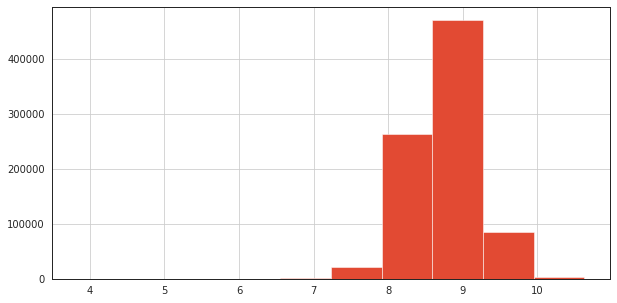

In [ ]:
rossmann["log_sales"].hist(figsize=(10,5))

In [ ]:
final = pd.merge(rossmann,store, on="Store")

In [ ]:
final.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales_x', 'Customers_x', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Month', 'Year', 'log_sales',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Sales_y',
       'Customers_y'],
      dtype='object')

In [ ]:
final.fillna(0,inplace=True)

In [ ]:
final.StateHoliday.value_counts()

0    843428
1       910
Name: StateHoliday, dtype: int64

In [ ]:
final.head().Date

0    2015-07
1    2015-07
2    2015-07
3    2015-07
4    2015-07
Name: Date, dtype: object

In [ ]:
final=pd.get_dummies(final,columns=['StoreType','Assortment','Year'])

In [ ]:
final.head()

,Store,DayOfWeek,Date,Sales_x,Customers_x,Open,Promo,StateHoliday,SchoolHoliday,Month,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Year_2013,Year_2014,Year_2015
0,1,5,2015-07,5263,555,1,1,0,1,7,...,0,0,1,0,1,0,0,0,0,1
1,1,4,2015-07,5020,546,1,1,0,1,7,...,0,0,1,0,1,0,0,0,0,1
2,1,3,2015-07,4782,523,1,1,0,1,7,...,0,0,1,0,1,0,0,0,0,1
3,1,2,2015-07,5011,560,1,1,0,1,7,...,0,0,1,0,1,0,0,0,0,1
4,1,1,2015-07,6102,612,1,1,0,1,7,...,0,0,1,0,1,0,0,0,0,1


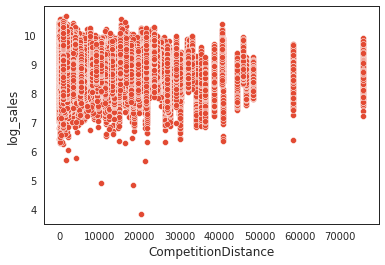

In [ ]:
sns.scatterplot(data=final,x='CompetitionDistance',y='log_sales')
plt.show()

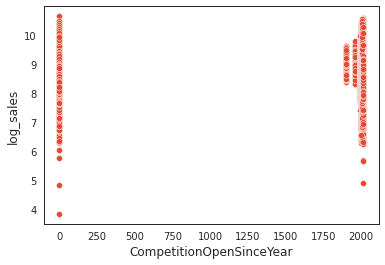

In [ ]:
sns.scatterplot(data=final,x='CompetitionOpenSinceYear',y='log_sales')
plt.show()

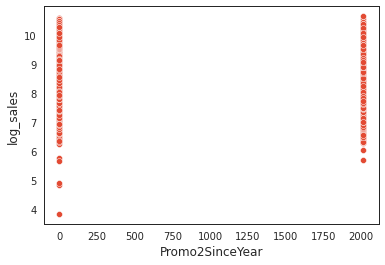

In [ ]:
sns.scatterplot(data=final,x='Promo2SinceYear',y='log_sales')
plt.show()

In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Date                       844338 non-null  object 
 3   Sales_x                    844338 non-null  int64  
 4   Customers_x                844338 non-null  int64  
 5   Open                       844338 non-null  int64  
 6   Promo                      844338 non-null  int64  
 7   StateHoliday               844338 non-null  int64  
 8   SchoolHoliday              844338 non-null  int64  
 9   Month                      844338 non-null  int64  
 10  log_sales                  844338 non-null  float64
 11  CompetitionDistance        844338 non-null  float64
 12  CompetitionOpenSinceMonth  844338 non-null  float64
 13  CompetitionOpenSinceYear   84

In [ ]:
vif = final.drop(["log_sales","Date","PromoInterval","StoreType_a","StoreType_b","StoreType_c","StoreType_d","Assortment_a","Assortment_b","Assortment_c","Year_2013","Year_2014","Year_2015"],axis =1)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = vif.columns
vif_data["VIF"] = [variance_inflation_factor(vif.values, i)
                          for i in range(len(vif.columns))]
  
print(vif_data)

                      feature            VIF
0                       Store       1.005844
1                   DayOfWeek       1.144093
2                     Sales_x      17.740181
3                 Customers_x      32.514430
4                        Open      28.882002
5                       Promo       1.662012
6                StateHoliday       1.009372
7               SchoolHoliday       1.034469
8                       Month       1.035269
9         CompetitionDistance       1.100646
10  CompetitionOpenSinceMonth       2.630623
11   CompetitionOpenSinceYear       2.629019
12                     Promo2  791826.852532
13            Promo2SinceWeek       2.545881
14            Promo2SinceYear  791300.191221
15                    Sales_y      13.523512
16                Customers_y      29.537384


In [ ]:
X = final.drop(['log_sales','Store','Date','Sales_x', 'Customers_x','Sales_y', 'Customers_y','CompetitionOpenSinceYear','Promo2SinceYear','PromoInterval'] , axis = 1)
y = final['log_sales']

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                      feature       VIF
0                   DayOfWeek  1.113600
1                        Open  0.000000
2                       Promo  1.092297
3                StateHoliday  1.014546
4               SchoolHoliday  1.034374
5                       Month  1.116274
6         CompetitionDistance  1.072832
7   CompetitionOpenSinceMonth  1.027565
8                      Promo2  2.400977
9             Promo2SinceWeek  2.392673
10                StoreType_a       inf
11                StoreType_b       inf
12                StoreType_c       inf
13                StoreType_d       inf
14               Assortment_a       inf
15               Assortment_b       inf
16               Assortment_c       inf
17                  Year_2013       inf
18                  Year_2014       inf
19                  Year_2015       inf


In [ ]:
X.columns

Index(['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Month',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'Promo2',
       'Promo2SinceWeek', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c',
       'Year_2013', 'Year_2014', 'Year_2015'],
      dtype='object')

In [ ]:
X.shape

(844338, 20)

In [ ]:
y.shape

(844338,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

#Model Building 

#Linear Regression

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train , y_train)
y_pred = reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mse = mean_squared_error(y_test,y_pred)
r2_lr = r2_score(y_test,y_pred)
print("rmse: ",rmse)
print("mse: ",mse)
print("r2: ",r2_lr)

rmse:  0.37317056137445515
mse:  0.13925626787652598
r2:  0.2337091859317988


###**All the grid searchs are performed piecewise and looked for locally best parameters and thereafter shifted to the new parameters accordingly to make it computationally less expensive .**

#Ridge

In [ ]:
model = linear_model.Ridge(random_state = 1)

param_grid = {
"alpha" : [0.01 , 0.2 , 0.250 , 0.3] 
}
grid = GridSearchCV( model , param_grid , cv = 5 , scoring = "neg_mean_squared_error")
grid.fit(X,y)

GridSearchCV(cv=5, estimator=Ridge(random_state=1),
             param_grid={'alpha': [0.01, 0.2, 0.25, 0.3]},
             scoring='neg_mean_squared_error')

In [ ]:
grid.best_score_

-0.14081048484182873

In [ ]:
grid.best_params_

{'alpha': 0.3}

In [ ]:
rmse = np.sqrt(-grid.best_score_)
rmse

0.3752472316244701

**Even after repeated PIECE WISE gridsearchCV the min RMSE is 0.3749 which is still greater than linear regression using Ordinary Least Squares**







#Lasso

In [ ]:
model = linear_model.Lasso(random_state = 1)

param_grid = {
"alpha" : [0.001 , 0.0001] ,
"max_iter" : [600 , 700]
}
grid = GridSearchCV( model , param_grid , cv = 7 , scoring = "neg_mean_squared_error")
grid.fit(X,y)

GridSearchCV(cv=7, estimator=Lasso(random_state=1),
             param_grid={'alpha': [0.001, 0.0001], 'max_iter': [600, 700]},
             scoring='neg_mean_squared_error')

**Though alpha is checked for 10^-4 learning rate which is very low and very slow to train but the initial piece-wise checkings with LASSO favoured low learning rates so we have to check them .**

In [ ]:
grid.best_score_

-0.14031944678933436

In [ ]:
grid.best_params_

{'alpha': 0.001, 'max_iter': 600}

In [ ]:
rmse = np.sqrt(-grid.best_score_)
rmse

0.37459237417402713

#Decision tree regressor

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf.fit(X_train , y_train)
pred = clf.predict(X_test)

In [ ]:
dt_rmse = np.sqrt(mean_squared_error(y_test,pred))
dt_mse = mean_squared_error(y_test,pred)
dt_r2 = r2_score(y_test,pred)
print("rmse: ",dt_rmse)
print("mse: ",dt_mse)
print("r2_score: ",dt_r2)

rmse:  0.17588256024711724
mse:  0.030934674999080824
r2_score:  0.8297745756837366


**Without parameter tuning the decision tree regressor is giving 0.1758 as RMSE which is quite good in comparison with Lasso , Ridge , etc. But above training was not cross-validated as Lasso and Ridge were.**



## Ensemble Techniques

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100,max_depth=15)

rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

In [ ]:
mse_rf = mean_squared_error(y_test,rf_pred)
mse_rf

0.054732583767700065

In [ ]:
r2_rf = r2_score(y_test,rf_pred)
r2_rf

0.6988209090265531

In [ ]:
rmse_rf = np.sqrt(mean_squared_error(y_test,rf_pred))
rmse_rf

0.23394995996516021

##XGBRegressor

**The parameters in the XGBRegressor have been tuned and only showed one of the best here.**


In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
xgb.fit(X_train,y_train)
xg_pred = xgb.predict(X_test)

[13:14:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
mse_xgb = mean_squared_error(y_test,xg_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test,xg_pred))
r2_xgb = r2_score(y_test,xg_pred)
print("mse: ",mse_xgb)
print("rmse: ",rmse_xgb)
print("r2_score: ",r2_xgb)

mse:  0.01676851496952229
rmse:  0.129493300867351
r2_score:  0.9077272485996585


In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
scores = cross_val_score(xgb, X , y , cv=5)
scores

[13:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.20192842, 0.17939616, 0.09593488, 0.16593964, 0.15749228])

**Cross validations upto 5 also yielded a minimum of 0.09593 which is less than any other model's RMSE.**

Now training on full data and predicting using new trained model.

In [ ]:
xgb_final = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
xgb_final.fit(X,y)

[15:06:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=15, n_estimators=120, n_jobs=4, subsample=0.7)

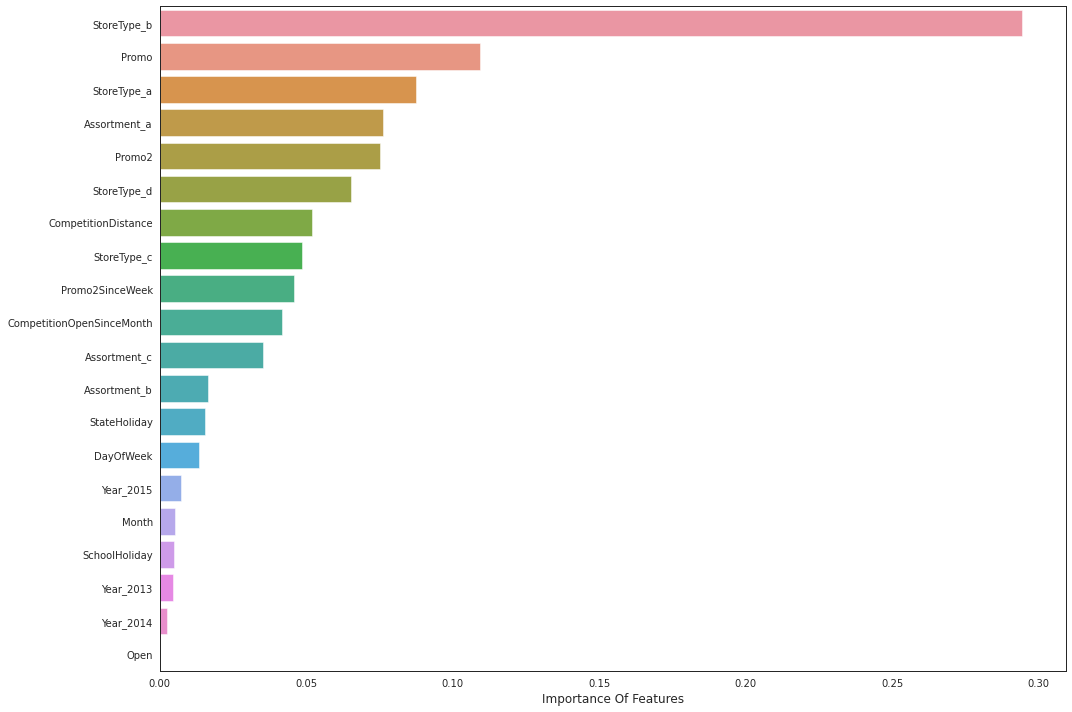

In [ ]:
ranks = np.argsort(-xgb_final.feature_importances_)
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x=xgb_final.feature_importances_[ranks], y=X_train.columns.values[ranks], orient='h')
ax.set_xlabel("Importance Of Features")
plt.tight_layout()
plt.show()

In [ ]:
X_test.columns

Index(['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Month',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'Promo2',
       'Promo2SinceWeek', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c',
       'Year_2013', 'Year_2014', 'Year_2015'],
      dtype='object')

In [ ]:
final_predictions = xgb_final.predict(X_test)

In [ ]:
final_predictions.shape

(168868,)

In [ ]:
X_test.shape

(168868, 20)

In [ ]:
X_test["Sales"] = np.exp(final_predictions).tolist()

In [ ]:
X_test.head()

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Month,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,...,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Year_2013,Year_2014,Year_2015,Sales
71824,3,1,1,0,0,8,1890.0,10.0,0,0.0,...,0,0,0,1,0,0,1,0,0,8810.783203
819009,3,1,1,0,0,11,190.0,0.0,1,13.0,...,0,0,0,1,0,0,1,0,0,6413.833984
385172,5,1,1,0,1,10,8260.0,0.0,0,0.0,...,0,0,0,0,0,1,0,1,0,8345.685547
191908,4,1,0,0,0,2,4630.0,3.0,1,35.0,...,0,1,0,0,0,1,1,0,0,5033.800781
191203,5,1,1,0,0,6,4630.0,3.0,1,35.0,...,0,1,0,0,0,1,0,0,1,7587.609375


In [ ]:
Final_data = X_test.copy()

In [ ]:
Final_data.sort_index(ascending = True).Sales.head()

3     7362.134766
4     8227.487305
6     5338.952148
18    5338.952148
29    5731.881348
Name: Sales, dtype: float64

The above dataframe is the predicted data form the given dataset.